In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import requests
import warnings
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
warnings.filterwarnings('ignore')

# Data loading and overview

In [20]:
train_df = pd.read_csv("dev.csv")
test_df = pd.read_csv("compete.csv")

In [21]:
# Get categorical features
categorical_features = list(train_df.columns[train_df.dtypes == object].values)
print(f'Categorical features: {categorical_features}')

# Get numerical features
numerical_features = list(train_df.columns[train_df.dtypes != object].values[:-1])
print(f'Numerical features: {numerical_features}')

Categorical features: ['protocol_type', 'service', 'flag']
Numerical features: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [22]:
cardinality = (train_df[categorical_features].nunique() / train_df[categorical_features].count())
print(f'Cardinality:\n\n{cardinality}')
to_drop = cardinality.index[cardinality > 0.5].values
for feat in to_drop:
    train_df = train_df.drop(feat, axis=1)
    categorical_features.remove(feat)
print(f'\nFeatures dropped: {to_drop}')

Cardinality:

protocol_type    0.000009
service          0.000191
flag             0.000032
dtype: float64

Features dropped: []


In [23]:
train_df = pd.get_dummies(train_df, columns=['protocol_type'])
test_df = pd.get_dummies(test_df, columns=['protocol_type'])

In [24]:
from sklearn import preprocessing

cat_cols = ['service', 'flag']
for col in cat_cols:
    if col in train_df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train_df[col].astype(str).values) + list(test_df[col].astype(str).values))
        train_df[col] = le.transform(list(train_df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))   

In [25]:
from sklearn.model_selection import train_test_split

X = train_df.drop('class', axis=1)
y = train_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [26]:
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
#X_train, y_train = rus.fit_resample(X_train, y_train)

In [27]:
numerical_features = list(train_df.columns[train_df.dtypes != object].values[:-1])
categorical_features = list(train_df.columns[train_df.dtypes == object].values)


Features dropped: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_icmp']


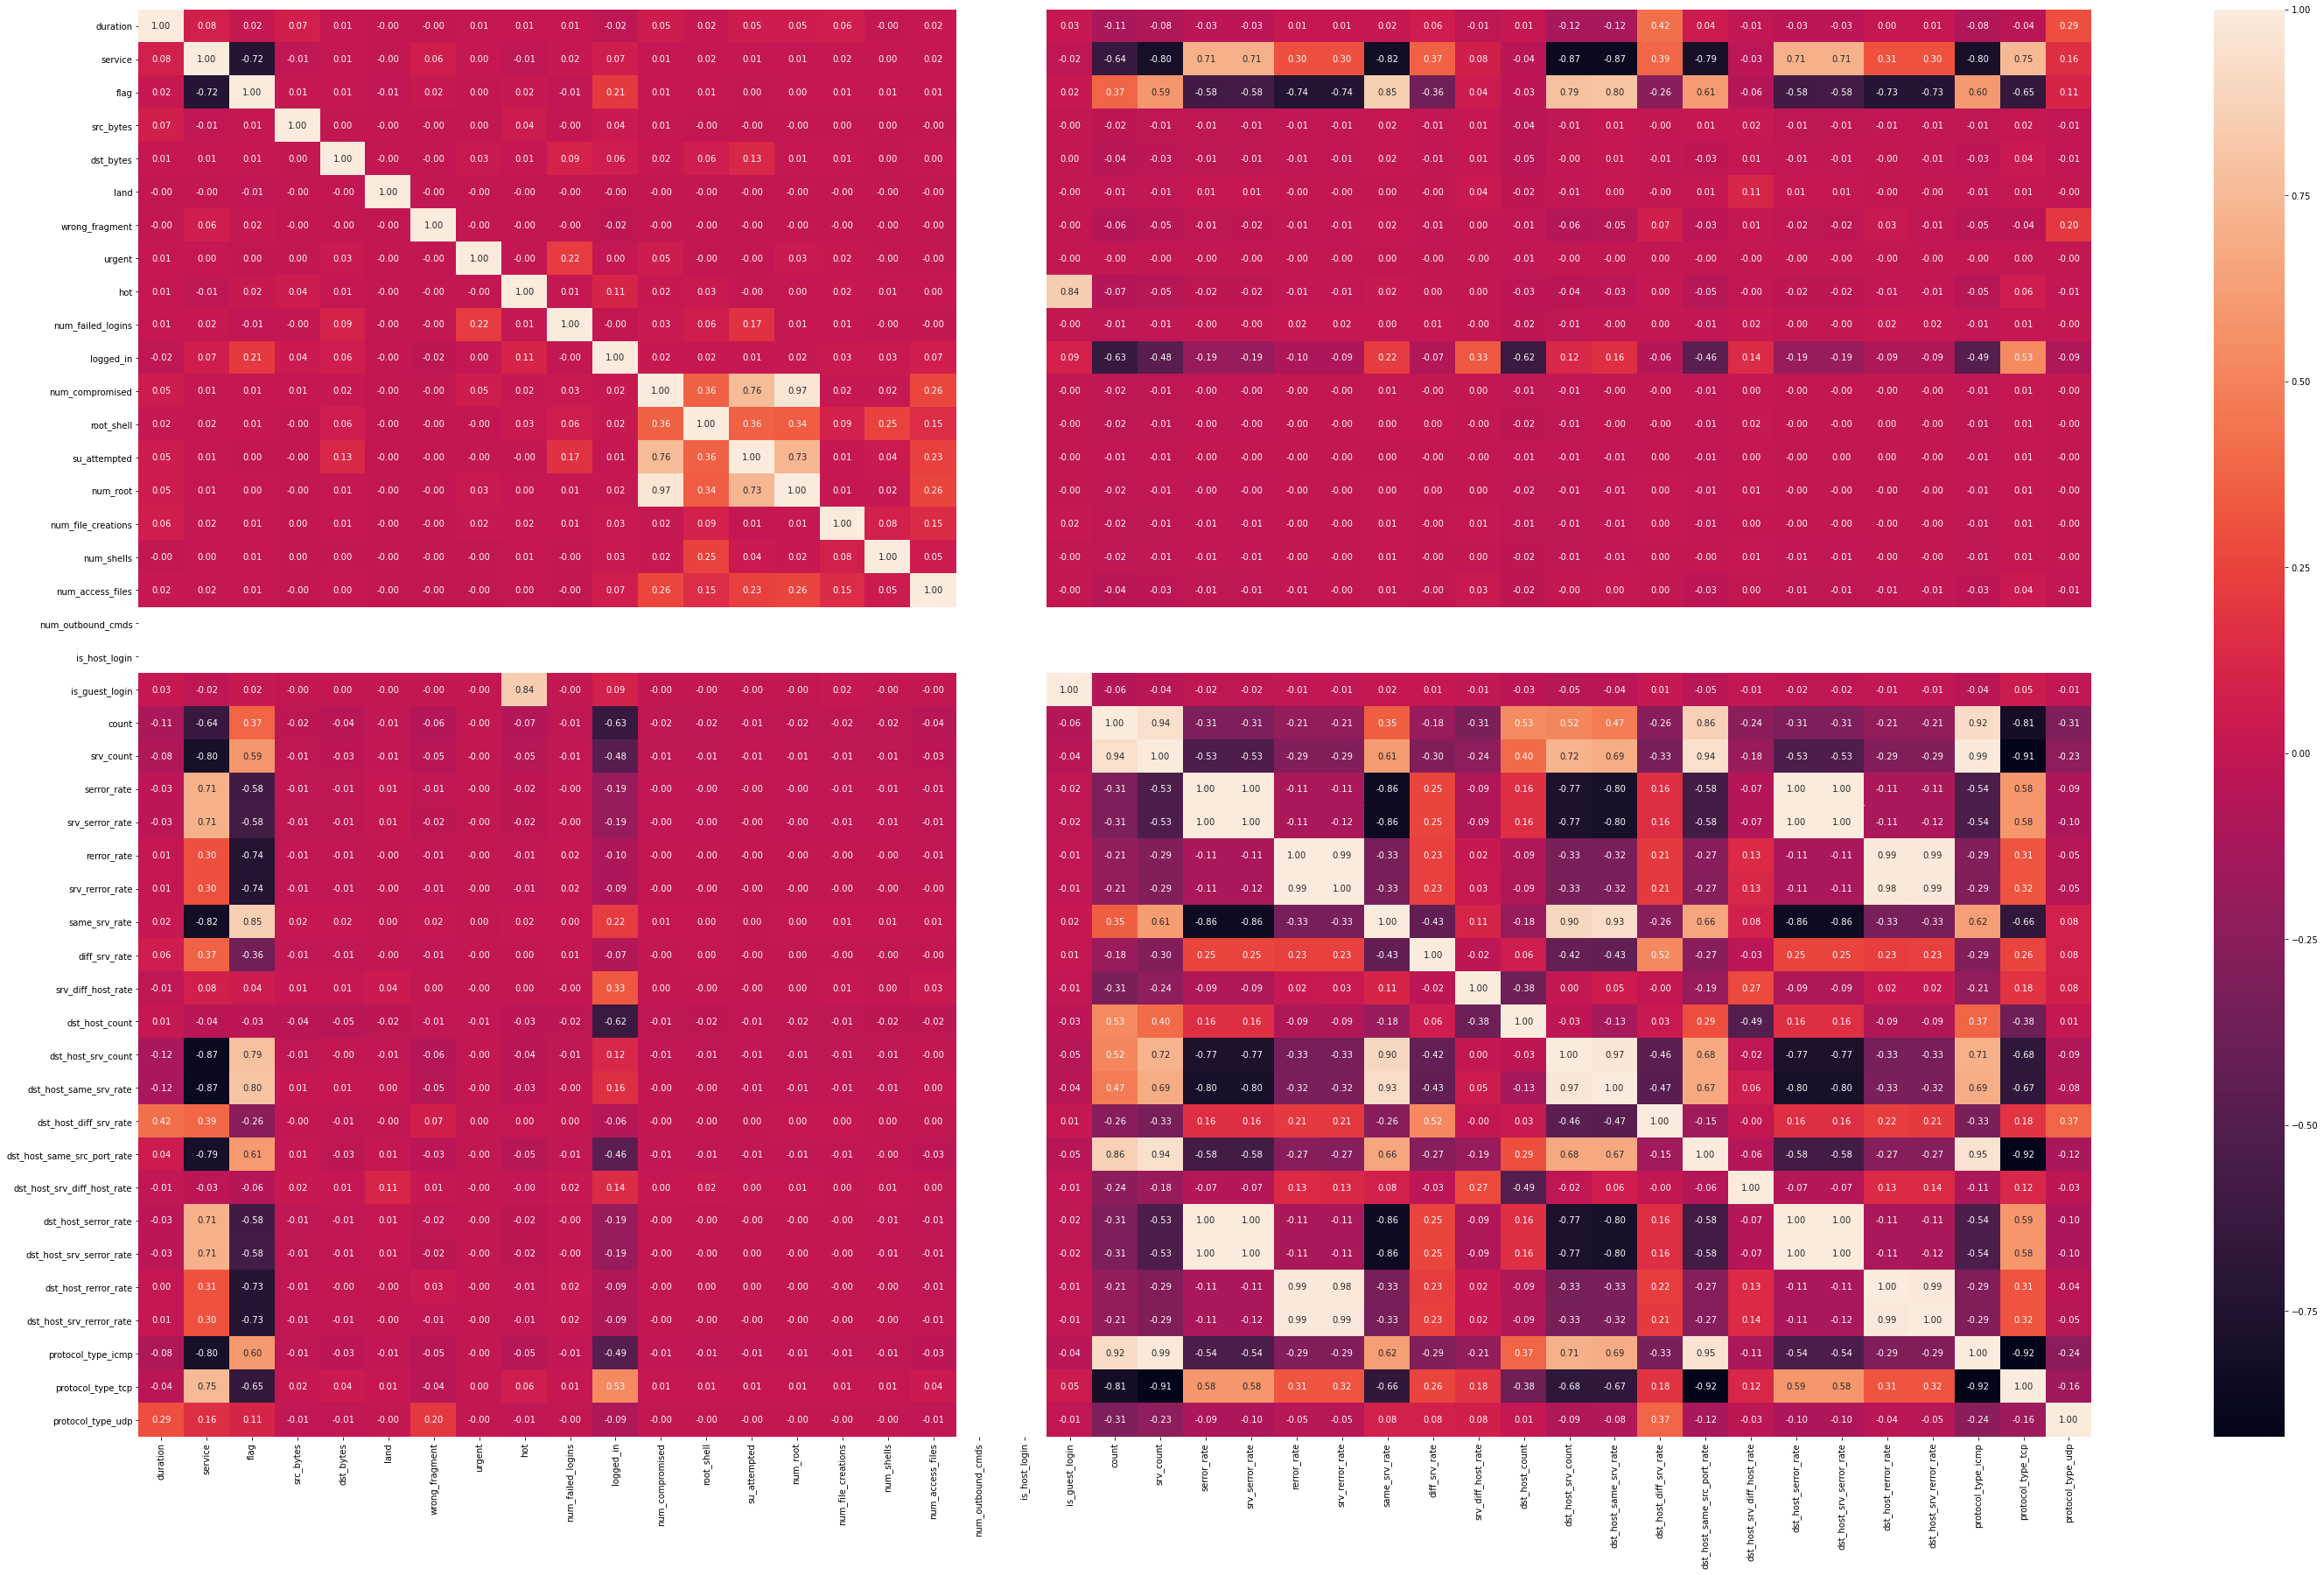

In [28]:
corr_table = X_train.corr()
triu = corr_table.where(np.triu(np.ones(corr_table.shape) ,k=1).astype(np.bool))
to_drop = [feat for feat in triu.columns if any(triu[feat] > 0.95)]

X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

for feat in to_drop:
    if feat in categorical_features:
        categorical_features.remove(feat)
    else:
        numerical_features.remove(feat)

print(f'\nFeatures dropped: {to_drop}')
plt.figure(figsize=(50, 30))
_ = sns.heatmap(corr_table, annot=True, fmt='.2f')

In [29]:
print(f'Training dataset dimensions: {X_train.shape}')
print(f'Test dataset dimensions: {X_test.shape}')
X_train.describe()

Training dataset dimensions: (242070, 34)
Test dataset dimensions: (103745, 34)


,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,protocol_type_tcp,protocol_type_udp
count,242070.000000,242070.000000,242070.000000,2.420700e+05,2.420700e+05,242070.000000,242070.000000,242070.000000,242070.000000,242070.000000,...,242070.000000,242070.000000,242070.000000,242070.000000,242070.000000,242070.000000,242070.000000,242070.000000,242070.000000,242070.000000
mean,47.421523,23.409667,7.843066,1.586285e+03,8.271819e+02,0.000041,0.006089,0.000012,0.035184,0.000174,...,0.791773,0.020959,0.029097,232.439584,188.640749,0.030974,0.602159,0.006651,0.384591,0.041410
std,684.922181,13.544946,2.252489,5.637444e+04,2.909530e+04,0.006427,0.130982,0.006097,0.790492,0.018848,...,0.388027,0.081922,0.142949,64.767988,106.021288,0.109436,0.481270,0.041944,0.486500,0.199236
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,14.000000,9.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,255.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,14.000000,9.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,255.000000,255.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,40.000000,9.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,255.000000,255.000000,0.040000,1.000000,0.000000,1.000000,0.000000
max,42088.000000,65.000000,10.000000,5.135678e+06,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,...,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf_rf.fit(X_train, y_train)

y_pred_test = clf_rf.predict_proba(X_test)
y_pred_test_hat = clf_rf.predict(X_test)
print('Test set results:')
display(pd.DataFrame(classification_report(y_test, y_pred_test_hat, output_dict=True)).transpose())

Test set results:


,precision,recall,f1-score,support
0,0.998967,0.999754,0.999360,20307.000000
1,0.999940,0.999748,0.999844,83438.000000
accuracy,0.999749,0.999749,0.999749,0.999749
macro avg,0.999453,0.999751,0.999602,103745.000000
weighted avg,0.999750,0.999749,0.999749,103745.000000


In [36]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_pred_test[:, 1])
roc_value

0.9999997382516397

Confusion matrix:
 [[20302     5]
 [   21 83417]]


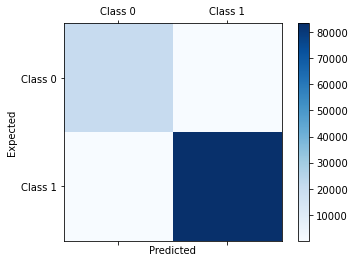

In [31]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_test_hat)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

---

In [14]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

xgb = XGBClassifier(n_estimators=100, verbosity = 0)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 99.98


---

In [18]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# predict the results
y_pred=clf.predict(X_test)

# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)

acc_lgm = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print("LightGBM's prediction accuracy is: %3.2f" % (acc_lgm))

LightGBM's prediction accuracy is: 99.98


In [19]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(random_state=0).fit(X_train, y_train)
preds_proba = clf_log.predict_proba(X_test)

preds_regression = clf_log.predict(X_test)

clf_log.score(X_test, y_test)

0.9837004192973156

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# logistic regression
model1 = LogisticRegression()
# knn
model2 = RandomForestClassifier(random_state=42, n_jobs=-1)

# fit model
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# predict probabilities
pred_prob1 = model1.predict_proba(X_test)
pred_prob2 = model2.predict_proba(X_test)

In [39]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [43]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])

print(auc_score1, auc_score2)

0.9967212013444012 0.9999997382516397


In [44]:
from sklearn.model_selection import cross_val_score

xgb_cv = XGBClassifier(n_estimators=100, verbosity = 0)
scores = cross_val_score(model2, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99983476 0.99971083 0.99983476 0.99983476 0.99983476 0.99971083
 0.99971083 0.99983476 0.99983476 0.9995869 ]
Mean: 0.9997727929937621
Standard Deviation: 8.31355054220016e-05


In [ ]:
test_df = test_df.drop(to_drop, axis=1)
test_id = test_df.Id.values
test_df = test_df.drop("Id", axis=1)

In [ ]:
preds = clf.predict(test_df)
preds_xgb = xgb.predict(test_df)

In [ ]:
submit = pd.DataFrame({'Id': test_id, 'class':preds})
submit.to_csv('Baseline.csv', index=False)

In [ ]:
submit = pd.DataFrame({'Id': test_id, 'class':preds_xgb})
submit.to_csv('XGB.csv', index=False)